# Encoding Word Embeddings with Hand Picked Features

URLS

# Constants

Here, you can alter the dataset, maximum number of samples to use, etc.

In [ ]:
DMOZ, ILP, PHISHING = 'dmoz', 'ilp', 'phishing'

DATASET = DMOZ  # one of the above datsets
MAX_NUM_SAMPLES = 1_000_000

TEST_PROP = 0.2
VAL_PROP = 0.2
EPOCHS = 8

SEED = 42

## Setup


You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [ ]:
GITHUB_TOKEN = 'fe2e680f071553cddb5f698cc58373a5106380d4'
command = f'git clone --depth 1 https://{GITHUB_TOKEN}@github.com/shmulvad/nlp-project.git'
!{command}

%cd nlp-project/src

fatal: destination path 'nlp-project' already exists and is not an empty directory.
/content/nlp-project/src


In [ ]:
!pip install gdown

# DMOZ, ILP and original phishing dataset - datasets.pkl
!gdown --id 1WV1JSevCnaWY0-mqQMmtOEFSC3Y_Qdg_

print('\n')
!ls

Downloading...
From: https://drive.google.com/uc?id=1WV1JSevCnaWY0-mqQMmtOEFSC3Y_Qdg_
To: /content/nlp-project/src/datasets.pkl
99.4MB [00:00, 108MB/s] 


baselines			     __pycache__
create_fasttext_embed.py	     read_data.py
data				     requirements.txt
datasets.pkl			     self_trained_embeddings.py
demo.ipynb			     tests
embed-dmoz.model		     url_tokenizer.py
embed-dmoz.model.vectors_ngrams.npy  util.py
featurizer.py			     word_embed
pickle_data.py


In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text
!pip install -q tf-models-official
!pip install -r requirements.txt

In [ ]:
import os
import shutil
import random
import pickle

from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from pprint import pprint
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import gensim
from gensim.models.keyedvectors import FastTextKeyedVectors

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
tf.get_logger().setLevel('ERROR')
np.random.seed(SEED)

from read_data import read_all_datasets
from url_tokenizer import url_tokenizer, flatten_url_data
from featurizer import UrlFeaturizer, GLOVE, CONCEPTNET, SAMPLE

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [ ]:
with open('datasets.pkl', 'rb') as f:
  datasets = pickle.load(f)

assert DATASET in datasets, \
  f'You tried to load {DATASET} but only {list(datasets.keys())} available.'

dataset = datasets[DATASET]
dataset

,idx,url,label
946066,946067,http://www.thepipe.info,Recreation
1322925,1322926,http://childlifeline.org,Society
1538731,1538732,http://www.fchd.info/fleett.htm,Sports
529412,529413,http://www.ee.umn.edu/users/kieffer/,Computers
639891,639892,http://www.ftprush.com,Computers
...,...,...,...
1467240,1467241,http://www.usatoday.com/sports/college/mensbas...,Sports
483946,483947,http://www.appraisal.co.nz/,Business
900141,900142,http://www.wild-about-hunting.com/,Recreation
320948,320949,http://www.searchlites.com/,Business


In [ ]:
# Download respectively model and ngrams
if DATASET == DMOZ:
  !gdown --id 1V8_EWQTF_JhgEVbXIvAiHViTHyIO9CBS
  !gdown --id 15EirC5KybMrG33RvYUXIfnBM2GWSBdh5
elif DATASET == ILP:
  !gdown --id 1_QafULaXKmq0H0fwY3dkR-WOKwsyUkHS
  !gdown --id 1kn4EbllSLdAX-8Ca5db6_BewLugCAWp5
else:  # Phishing
  !gdown --id 1JEsUG4eGqbIItBH468xph-AsS3iQ5Fif
  !gdown --id 10p0XPRsuTsXblQNNlUricEmd8if0B2P6

embedding = FastTextKeyedVectors.load(f'embed-{DATASET}.model')

Downloading...
From: https://drive.google.com/uc?id=1V8_EWQTF_JhgEVbXIvAiHViTHyIO9CBS
To: /content/nlp-project/src/embed-dmoz.model
23.0MB [00:00, 108MB/s] 
Downloading...
From: https://drive.google.com/uc?id=15EirC5KybMrG33RvYUXIfnBM2GWSBdh5
To: /content/nlp-project/src/embed-dmoz.model.vectors_ngrams.npy
800MB [00:04, 189MB/s]


In [ ]:
feat = UrlFeaturizer(embedding=embedding)

Creating the average vector of all the word vectors...
Created FastText UrlFeaturizer in 0.0 s


# Testing models on current embedding

In [ ]:
import re
import pandas as pd

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Bidirectional, TimeDistributed, Conv1D, ZeroPadding1D, GRU
from tensorflow.keras.layers import Lambda, Input, Dropout, Masking, BatchNormalization, Activation
from tensorflow.keras.models import Model

from tqdm import tqdm

Below I extract a subset of the data to experiment with. You can change the *n_samples* value to change the dataset length

In [ ]:
n_samples = 1000
sampled_dataset = dataset.sample(n = n_samples)

## Trying different approaches to Encode

### Method 1 - FLatten

Here we simply flatten the word embeddings for each URL and append the handpicked featrues

Thus, the (31,100) embeddings are flattened to (3100,) vector.
Further appending the handpicked features makes the vector shape: (3120,)


In [ ]:
url_regex = re.compile(r'''
        (https?):\/\/                                   # http s
        ([-a-zA-Z0-9@:%._\+~#=]+\.[a-zA-Z0-9()]{1,12})  # domains
        \b
        ([-a-zA-Z0-9()@:%_\+;.~#&//=]*)                 # path
        \??
        ([-a-zA-Z0-9()@:%_\+;.~#&//=?]*)                # args
    ''', re.DOTALL | re.VERBOSE)

def GenerateFeatureVector_Flatten(df, UF):
    df.reset_index(drop = True, inplace = True)
    df = pd.get_dummies(data=df, columns=['label'])
    label = df.drop(['idx','url'],axis=1).values

    url_features = list()
    labels = list()

    for i in tqdm(range(df.shape[0])):
        url = df.iloc[i].url
        match = url_regex.match(url.lower())
        if match:
            features = UF.featurize(url)
            temp =   features[1].flatten()
            labels.append(label[i])
            url_features.append(np.concatenate((temp,features[0])))

    url_features = np.array(url_features)
    labels = np.array(labels)
    return url_features,labels

In [ ]:
url_features,labels = GenerateFeatureVector_Flatten(sampled_dataset,feat)

100%|██████████| 1000/1000 [00:00<00:00, 2251.21it/s]


In [ ]:
url_features.shape

(10000, 3120)

### Encoder-1 --> Encode entire matrix together

This is the same encoder as we had discussed during the project consultation with prof. The LSTM here is used to input the word emeddings and transforms the entire embedding at once to a linear vector

In [ ]:
def valid_url(url):
  match = url_regex.match(url.lower())
  if match:
    return True
  else:
    return False

url_regex = re.compile(r'''
        (https?):\/\/                                   # http s
        ([-a-zA-Z0-9@:%._\+~#=]+\.[a-zA-Z0-9()]{1,12})  # domains
        \b
        ([-a-zA-Z0-9()@:%_\+;.~#&//=]*)                 # path
        \??
        ([-a-zA-Z0-9()@:%_\+;.~#&//=?]*)                # args
    ''', re.DOTALL | re.VERBOSE)

In [ ]:
def GenerateFeatureVector_Enc1(dataset, UF):
    df = sampled_dataset.copy()

    df.reset_index(drop = True, inplace = True)
    df['valid'] = df.url.apply(lambda x:valid_url(x))
    df = df[df['valid']==True]
    df.drop(['valid'],axis=1,inplace=True)
    df = pd.get_dummies(data=df, columns=['label'])
    labels = df.drop(['idx','url'],axis=1).values

    raw_features = feat.featurize(np.array(df.url))

    embeddings = list()
    hand_picked = list()
    for feature in raw_features:
      embeddings.append(feature[1])
      hand_picked.append(feature[0])

    raw_features = None
    embeddings = np.array(embeddings)
    hand_picked = np.array(hand_picked)

    inputs1 = Input(shape=(31, 100))
    lstm1 = LSTM(100)(inputs1)
    model1 = Model(inputs=inputs1, outputs=lstm1)

    embeddings_encoded = model1.predict(embeddings)

    features = np.concatenate([embeddings_encoded,hand_picked],axis=1)

    return features,labels

In [ ]:
url_features,labels = GenerateFeatureVector_Enc1(sampled_dataset,feat)

100%|██████████| 1000/1000 [00:33<00:00, 29.85it/s]


### Enocoder 2 --> Piecewise

In [ ]:
def valid_url(url):
  match = url_regex.match(url.lower())
  if match:
    return True
  else:
    return False

url_regex = re.compile(r'''
        (https?):\/\/                                   # http s
        ([-a-zA-Z0-9@:%._\+~#=]+\.[a-zA-Z0-9()]{1,12})  # domains
        \b
        ([-a-zA-Z0-9()@:%_\+;.~#&//=]*)                 # path
        \??
        ([-a-zA-Z0-9()@:%_\+;.~#&//=?]*)                # args
    ''', re.DOTALL | re.VERBOSE)

In [ ]:
def GenerateFeatureVector_Enc2(dataset, UF):
    df = dataset.copy()

    df.reset_index(drop = True, inplace = True)
    df['valid'] = df.url.apply(lambda x:valid_url(x))
    df = df[df['valid']==True]
    df.drop(['valid'],axis=1,inplace=True)
    df = pd.get_dummies(data=df, columns=['label'])
    labels = df.drop(['idx','url'],axis=1).values

    raw_features = feat.featurize(np.array(df.url))

    embeddings = list()
    hand_picked = list()
    for feature in raw_features:
      embeddings.append(feature[1])
      hand_picked.append(feature[0])

    embeddings = np.array(embeddings)
    hand_picked = np.array(hand_picked)

    sub_domain = embeddings[:,:5,:]
    main_domain = embeddings[:,5:10,:]
    domain_end_vec = embeddings[:,10,:]
    path = embeddings[:,11:21,:]
    arg = embeddings[:,21:,:]

    inputs1 = Input(shape=(5, 100))
    lstm1 = LSTM(100)(inputs1)
    model1 = Model(inputs=inputs1, outputs=lstm1)

    inputs2 = Input(shape=(10, 100))
    lstm2 = LSTM(100)(inputs2)
    model2 = Model(inputs=inputs2, outputs=lstm2)

    sub_domain_encoded = model1.predict(sub_domain)
    main_domain_encoded = model1.predict(main_domain)
    path_encoded = model2.predict(path)
    arg_encoded = model2.predict(arg)

    features = np.concatenate([sub_domain_encoded,main_domain_encoded,domain_end_vec,path_encoded,arg_encoded,hand_picked],axis=1)

    return features,labels

In [ ]:
url_features, labels = GenerateFeatureVector_Enc2(sampled_dataset,feat)

## Testing the generated Features

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(url_features,labels,test_size=0.2)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,Y_train)
Y_RF_pred=rf.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(Y_test,Y_RF_pred))

              precision    recall  f1-score   support

           0       1.00      0.03      0.05        39
           1       0.90      0.19      0.31       331
           2       0.67      0.04      0.08       293
           3       1.00      0.08      0.15       150
           4       0.65      0.15      0.25        72
           5       1.00      0.03      0.06        69
           6       0.75      0.10      0.18        30
           7       0.50      0.01      0.03        71
           8       0.00      0.00      0.00        11
           9       0.67      0.02      0.03       114
          10       0.53      0.10      0.17        79
          11       0.89      0.06      0.11       141
          12       0.00      0.00      0.00       131
          13       0.78      0.16      0.27       330
          14       0.94      0.12      0.22       139

   micro avg       0.81      0.10      0.17      2000
   macro avg       0.69      0.07      0.13      2000
weighted avg       0.74   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Deep Model

The deep models take 3 dimmentional inputs, which has been taken care of below

In [ ]:
url_features_deep = url_features.reshape(url_features.shape[0],url_features.shape[1],1)
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(url_features_deep,labels,test_size=0.2)

This is a very Basic Deep Architecture that is being used below. You can feel free to try out newer set of parameters/ architecture

In [ ]:
def cnn_lstm(input_dim, output_dim, dropout=0.2, n_layers=1):
    dtype = 'float64'
    input_data = Input(name='the_input', shape=input_dim, dtype=dtype)
#     x = Conv1D(filters=256, kernel_size=10, strides=4, name='conv_1')(input_data)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Dropout(dropout, name='dropout_1')(x)
        
    x = LSTM(128, activation='tanh', return_sequences=True,dropout=dropout, name='lstm_1')(input_data)
    x = LSTM(128, activation='tanh', return_sequences=False,dropout=dropout, name='lstm_2')(x)

    # 1 fully connected layer DNN ReLu with default 20% dropout
    x = Dense(units=64, activation='tanh', name='fc')(x)
    x = Dropout(dropout, name='dropout_2')(x)

    # Output layer with softmax
    y_pred = Dense(units=output_dim, activation='softmax', name='softmax')(x)
    model = Model(inputs=input_data, outputs=y_pred)   
    return model

input_dim = (url_features_deep.shape[1],1)
classes = labels.shape[1]
K.clear_session()
model = cnn_lstm(input_dim, classes)
model.summary()

The below piece of code is used to actually train the deep model as initialised above

I have included *EarlyStopping* to stop training the model once the loss stops changing

It is also common practice to use a scheduler to decay your learning rate. I have used *ReduceLROnPlateau* to take care of that part

Again, as Soeren had discuseed during the meeting, using different loss functions, optimizers, learning rate etc. can help improve the model performance

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

sgd = SGD()
adam = Adam()

checkpoint = ModelCheckpoint('checkpoint', monitor='val_loss', verbose=0,
                                 save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss",
                              mode="min",
                              patience=5)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.7,
                                           patience=2,
                                           verbose=1, mode='min', min_delta=0.0001, cooldown=3,
                                           min_lr=1e-9)  # epsilon here is a good starting value


# , clipnorm=1.0

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
history = model.fit(X_train, Y_train,
                    batch_size=128, epochs=50,
                    validation_data=(X_test, Y_test),
                    callbacks=[checkpoint, early, reduceLROnPlat])

NameError: ignored

### SVM

In [ ]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train,Y_train)
Y_SVM_pred=svc.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(Y_test,Y_SVM_pred))

# Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yeld even better accuracy but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/tutorials/text/solve_glue_tasks_using_bert_on_tpu).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-2_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [ ]:
test_url = dataset['url'].iloc[0]
url_data = url_tokenizer(test_url)
url_flat_lst = flatten_url_data(url_data)
url_flat = ' '.join(url_flat_lst)

text_preprocessed = bert_preprocess_model([url_flat])

print(f'URL        : {test_url}')
print(f'URL flat   : {url_flat}')
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

URL        : http://www.thepipe.info
URL flat   : http www the pipe info
Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  8299  7479  1996  8667 18558   102     0     0     0     0     0]
Input Mask : [1 1 1 1 1 1 1 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/tutorials/text/solve_glue_tasks_using_bert_on_tpu).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.00361862  0.9974153  -0.99529904 -0.22447681 -0.9434776   0.62250006
  0.2588993  -0.13676798 -0.986421   -0.35827443 -0.06381412 -0.40712824]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.00662175  0.33793622  0.16519605 ...  0.39938825  0.17727904
   0.37628025]
 [-0.23351899  0.3960936   0.31572118 ... -0.5405884   0.2409601
   0.75649756]
 [ 0.42145604  0.06643031  0.78035384 ... -0.19821838 -0.3319409
   0.45022073]
 ...
 [ 0.0887524   0.7291727  -0.45450005 ...  0.3496972   0.17700732
   0.05872215]
 [ 0.46900666  0.4190787   0.41059238 ...  0.0887006  -0.0083739
   0.24160132]
 [ 0.3521223   0.5305756   0.3649592  ... -0.08279605  0.04219715
   0.43598714]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` to represent each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can use just follow the model's url for documentation. Here specifically you don't need to worry about it because the preprocessing model will take care of that for you.


In [ ]:
if DATASET == 'dmoz':
  dataset = dataset.sample(MAX_NUM_SAMPLES)

dataset

,idx,url,label
1478154,1478155,http://www.physics.ubc.ca/~rcoope,Sports
1440788,1440789,http://www.divinity.cam.ac.uk/carts/gender.html,Society
557247,557248,http://deepblog.com/,Computers
956912,956913,http://www.tiaa.edu.ge/,Reference
333932,333933,http://www.firstediting.com,Business
...,...,...,...
639909,639910,http://www.codelifter.com/,Computers
1178456,1178457,http://www.semiprecious.com/,Shopping
1432785,1432786,http://www.geocities.com/lorrainesplace2002/,Society
195680,195681,http://www.cincyflute.com/,Arts


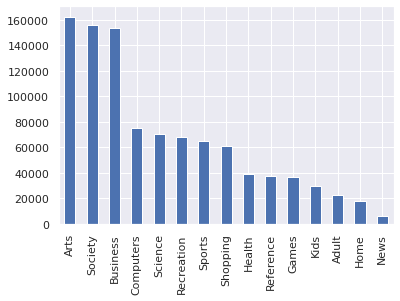

In [ ]:
dataset['label'].value_counts().plot(kind='bar')

In [ ]:
labels = np.array(dataset.label.unique())
label_to_num = {label: i for i, label in enumerate(labels)}
num_classes = len(label_to_num)

print('Num classes:', num_classes)
pprint(label_to_num)

Num classes: 15
{'Adult': 9,
 'Arts': 7,
 'Business': 4,
 'Computers': 2,
 'Games': 6,
 'Health': 10,
 'Home': 8,
 'Kids': 13,
 'News': 14,
 'Recreation': 5,
 'Reference': 3,
 'Science': 12,
 'Shopping': 11,
 'Society': 1,
 'Sports': 0}


In [ ]:
def build_classifier_model_custom():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(num_classes, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [ ]:
classifier_model = build_classifier_model_custom()
bert_raw_result = classifier_model(tf.constant([url_flat]))
print(tf.sigmoid(bert_raw_result))

tf.Tensor(
[[0.29074588 0.39552143 0.5697251  0.5167154  0.5072982  0.6216469
  0.64545816 0.23900901 0.5826868  0.19900523 0.3064908  0.49508867
  0.32405144 0.60189146 0.77026176]], shape=(1, 15), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

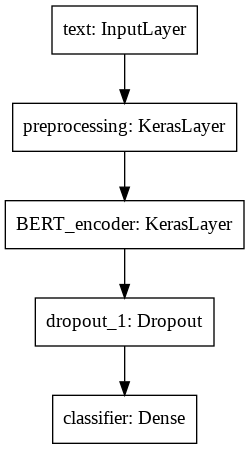

In [ ]:
tf.keras.utils.plot_model(classifier_model)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), we use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [ ]:
def clean_url(url: str) -> str:
  url_data = url_tokenizer(url)
  url_flat_lst = flatten_url_data(url_data)
  url_flat = ' '.join(url_flat_lst)
  return url_flat


dataset['urlClean'] = dataset['url'].apply(clean_url)

In [ ]:
dataset['sparseLabel'] = dataset['label'].map(label_to_num)
dataset

,idx,url,label,urlClean,sparseLabel
1478154,1478155,http://www.physics.ubc.ca/~rcoope,Sports,http www physics ubc ca r coop e,0
1440788,1440789,http://www.divinity.cam.ac.uk/carts/gender.html,Society,http www divinity cam ac uk carts gender html,1
557247,557248,http://deepblog.com/,Computers,http deep blog com,2
956912,956913,http://www.tiaa.edu.ge/,Reference,http www tiaa edu ge,3
333932,333933,http://www.firstediting.com,Business,http www first editing com,4
...,...,...,...,...,...
149559,149560,http://www.rollingstone.com/artists/janisian,Arts,http www rolling stone com artists janis ian,7
85056,85057,http://andybragen.com,Arts,http andy brage n com,7
175104,175105,http://www.wqxr.com/cgi-bin/iowa/cla/learning/...,Arts,http www wqxr com cgi bin iowa cla learning gr...,7
1214881,1214882,http://www.janhart.com/,Shopping,http www jan hart com,11


In [ ]:
X, y = dataset['urlClean'].to_numpy(), dataset['sparseLabel'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_PROP, random_state=SEED)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((80000,), (80000,), (20000,), (20000,))

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [ ]:
init_lr = 7e-5
optimizer_type='adamw'
num_train_steps = 3125
num_warmup_steps = 312

# use optimizer = optimization.create_optimizer()
optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type=optimizer_type
)

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [ ]:
%%time

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(
    x=X_train,
    y=y_train,
    validation_split=VAL_PROP,
    epochs=EPOCHS
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1
Epoch 1/8
2000/2000 [==============================] - 529s 262ms/step - loss: 2.0602 - sparse_categorical_accuracy: 0.3492 - val_loss: 1.5315 - val_sparse_categorical_accuracy: 0.5186
Epoch 2/8
2000/2000 [==============================] - 526s 263ms/step - loss: 1.4536 - sparse_categorical_accuracy: 0.5422 - val_loss: 1.5124 - val_sparse_categorical_accuracy: 0.5279
Epoch 3/8
2000/2000 [==============================] - 532s 266ms/step - loss: 1.4039 - sparse_categorical_accuracy: 0.5583 - val_loss: 1.5124 - val_sparse_categorical_accuracy: 0.5279
Epoch 4/8
2000/2000 [==============================] - 529s 265ms/step - loss: 1.4083 - sparse_categorical_accuracy: 0.5592 - val_loss: 1.5124 - val_sparse_categorical_accuracy: 0.5279
Epoch 5/8
2000/2000 [==============================] - 530s 265ms/step - loss: 1.4054 - sparse_categorical_accuracy: 0.5568 - val_loss: 1.5124 - val_sparse_categorical_

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [ ]:
# evaluation on the testing data
loss, accuracy = classifier_model.evaluate(x=X_test, y=y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

625/625 [==============================] - 76s 122ms/step - loss: 1.5109 - sparse_categorical_accuracy: 0.5290
Loss: 1.5108596086502075
Accuracy: 0.5290499925613403


In [ ]:
y_pred1 = classifier_model.predict(X_test)
y_pred = np.argmax(y_pred1, axis=1)

# Print f1, precision, and recall scores
print('Precision:', precision_score(y_test, y_pred , average="macro"))
print('Recall:   ', recall_score(y_test, y_pred , average="macro"))
print('F1:       ', f1_score(y_test, y_pred , average="macro"))

Precision: 0.5522222745502499
Recall:    0.4412119598205855
F1:        0.4751746478905378


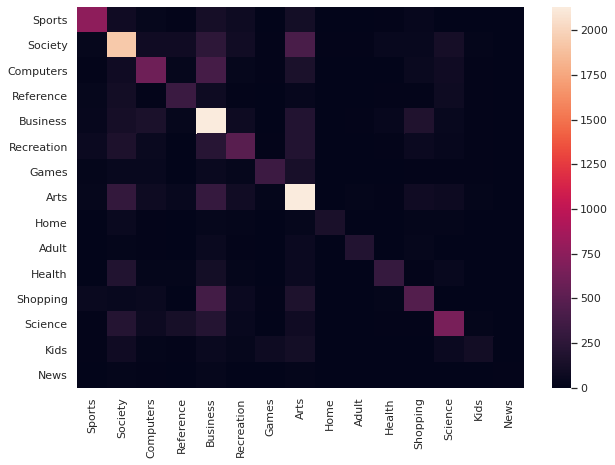

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=False, xticklabels=labels, yticklabels=labels)

### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


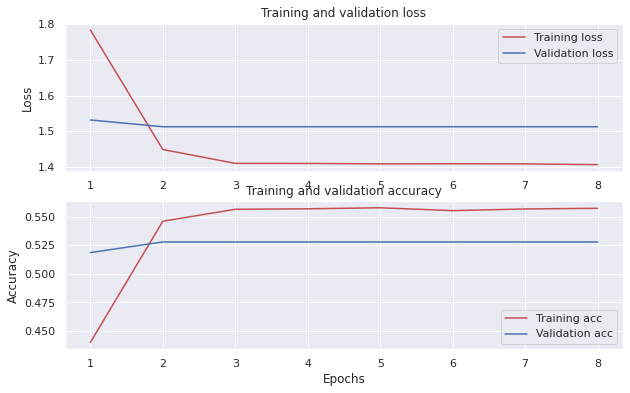

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represents the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Export for inference

Now you just save your fine-tuned model for later use.

In [ ]:
saved_model_path = './{}_bert'.format(DATASET)

classifier_model.save(saved_model_path, include_optimizer=False)

Let's reload the model so you can try it side by side with the model that is still in memory.

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test your model on any sentence you want, just add to the examples variable below.

In [ ]:
def print_my_examples(inputs, results):
  predicted = np.argmax(results, axis=1)
  for inp, res, pred in zip(inputs, results, predicted):
    msg = f'input: {inp:<35} : label : {labels[pred]:<10} : score: {res[pred]:.6f}'
    print(msg)
  print()


urls = dataset['url'].iloc[:5].to_numpy()
urls_flattened = [clean_url(url) for url in urls]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(urls_flattened)))
original_results = tf.sigmoid(classifier_model(tf.constant(urls_flattened)))

print('Results from the saved model:')
print_my_examples(urls_flattened, reloaded_results)
print('Results from the model in memory:')
print_my_examples(urls_flattened, original_results)

Results from the saved model:
input: http www physics ubc ca r coop e    : label : Science    : score: 0.992104
input: http www divinity cam ac uk carts gender html : label : Society    : score: 0.995186
input: http deep blog com                  : label : Computers  : score: 0.966104
input: http www tiaa edu ge                : label : Reference  : score: 0.989284
input: http www first editing com          : label : Business   : score: 0.988271

Results from the model in memory:
input: http www physics ubc ca r coop e    : label : Science    : score: 0.992104
input: http www divinity cam ac uk carts gender html : label : Society    : score: 0.995186
input: http deep blog com                  : label : Computers  : score: 0.966104
input: http www tiaa edu ge                : label : Reference  : score: 0.989284
input: http www first editing com          : label : Business   : score: 0.988271

